In [7]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

# Example usage
x_U = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
x_P = np.array([[2, 2], [3, 3]])

### Data Generation -- Gaussian Mixture 
def gen_data(
    k=2, 
    dim=2, 
    points_per_cluster=1000, 
    means=None, 
    covariances=None
):
    # Generate data from specified or random Gaussians
    if means is not None and covariances is None:
        raise ValueError("Covariances must be provided if means are provided.")
    if means is None:
        means = [np.random.rand(dim) for _ in range(k)]
    if covariances is None:
        covariances = [np.eye(dim) for _ in range(k)]
    x = []
    y = []
    for i in range(k):
        _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)
        x += list(_x)
        y += [i] * points_per_cluster
    x = np.array(x)
    y = np.array(y)
    return x, y

def create_positive_unlabeled(
    x, 
    y, 
    num_labeled, 
    means=None, 
    covariances=None, 
    setting='single_data'
):
    '''
    Creates positive examples (P) and unlabeled examples (0) based on given x and y.
    input:
        - x: Input data (total_examples, features)
        - y: True labels (total_examples,)
        - num_labeled: Number of positive examples (P)
    output:
        - labels: Generated labels (total_examples,)
    '''
    if setting == 'single_data':
        feat = x
        labels = np.zeros(len(y))               # Initialize labels with all 0 (unlabeled)
        positive_indices = np.where(y == 1)[0]  # Indices of positive examples in the true labels
        
        # Randomly select n positive examples
        selected_indices = np.random.choice(positive_indices, size=num_labeled, replace=False)
        labels[selected_indices] = 1            # Assign label 1 to selected positive examples
    
    elif setting == 'case_control':
        x_, y_ = gen_data(
            k=2, 
            dim=2, 
            points_per_cluster=num_labeled, 
            means=means, 
            covariances=covariances
        )
        ix = np.where(y_ == 1)[0]
        x_P = x_[ix]
        feat = np.concatenate((x, x_P), axis=0)
        labels_P = np.ones(num_labeled)
        labels_U = np.zeros(len(y)) 
        labels = np.concatenate((labels_U, labels_P), axis=0)
        

    return feat, labels


### Viz Data ---- Scatter Plot 
def plot_scatter(x, y, label_colors, model=None, lbl_map=None):
    # Plots a scatter plot of the generated data
    data = {'X': x[:, 0], 'Y': x[:, 1], 'Label': y}
    df = pd.DataFrame(data)
    if lbl_map is not None:
        df['Label'] = df['Label'].map(lbl_map)  # Map labels 0 to 'N' and 1 to 'P'
    sns.scatterplot(
        data=df, 
        x='X', 
        y='Y', 
        hue='Label', 
        palette=label_colors, 
        s=60, 
        alpha=0.8,
        edgecolor='k', 
        marker='o',
    )

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_50737/119958310.py:38: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


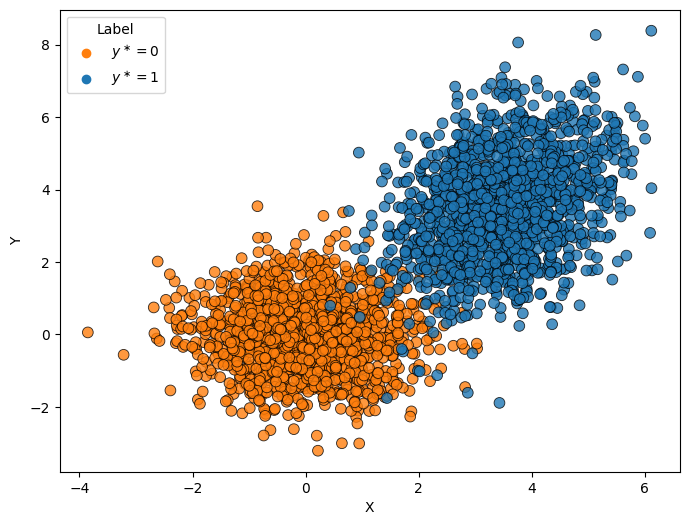

In [8]:
# Generate Data (PN) from Gaussians 
mean1 = np.array([0, 0])  # Mean of first cluster
cov1 = np.array([[0, 1], [1, 0]])  # Covariance matrix of first cluster

mean2 = np.array([3.5, 3.5])  # Mean of second cluster
cov2 = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix of second cluster

means = [mean1, mean2]
covariances = [cov1, cov2]

x, y = gen_data(
    k=2, 
    dim=2, 
    points_per_cluster=1500, 
    means=means, 
    covariances=covariances
)


label_colors = [
    '#ff7f0e', 
    '#1f77b4'
] 
lbl_map = {
    0: r'$y^\ast = 0$', 
    1: r'$y^\ast = 1$'
}
plt.figure(figsize=(8,6))
plot_scatter(x, y, label_colors, lbl_map=lbl_map)